<a href="https://colab.research.google.com/github/CarolBw/CB-AI-English-teacher/blob/main/CB_AI_English_teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto MVP CB-AI English teacher.
Trabalho de conclusão da Sprint Machine Learning & Analytics.
Pós graduação em Ciencia de Dados, PUC-RJ.



# Visão Geral

Este notebook contém o código para o desenvolvimento de um algoritmo professor de inglês utilizando técnicas de Processamento de Linguagem Natural (PNL) e Aprendizado de Máquina. O objetivo é criar um sistema capaz de entender consultas em inglês e fornecer respostas relevantes e informativas para auxiliar no aprendizado da língua inglesa.



# Preparação do Ambiente:





#### Instalando as dependencias >>

In [1]:
# Instalando as dependencias
!pip install tensorflow transformers nltk pandas scikit-learn matplotlib seaborn wordcloud
!pip install pyspellchecker
!pip install textblob

#### Importando as bibliotecas >>

In [2]:
# Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np

# Bibliotecas para plotagem de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para processamento de linguagem natural
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Ferramentas adicionais de NLP e tokenização
from transformers import BertTokenizer, TFBertForQuestionAnswering

# Bibliotecas para aprendizado de máquina e processamento de modelos
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Biblioteca para manipulação de texto e limpeza
import re
from collections import Counter
from wordcloud import WordCloud

# Bibliotecas para comunicação com a web e parsing de HTML
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse

# Biblioteca para interação com banco de dados
import sqlite3

# Biblioteca para interação com o Google Colab
from google.colab import files, drive

# Biblioteca para correção ortográfica
from spellchecker import SpellChecker

# Downloads e preparações necessárias para o NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Bibliotecas para pré-processamento de texto para modelos de deep learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import sent_tokenize
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Coleta e carregamento dos dados

  O conjunto de dados consiste em conteúdo textual de Wikibooks em inglês e português, organizado em capítulos e disponibilizado em formato de texto simples e HTML. Recriei o Dataset selecionando apenas estas duas linguagens a partir do conjunto original que continha o conteúdo em diversas outras linguagens.
  
Conjunto original em:
https://www.kaggle.com/datasets/dhruvildave/wikibooks-dataset/data

In [3]:
# Montar o Google Drive
drive.mount('/content/drive')

# Caminho para o arquivo no Google Drive
caminho_arquivo = '/content/drive/MyDrive/Data-Science_Analytics/Projetos/CB-AI English Teacher/wikibooks_pt_en_version.sqlite'

# Conectar ao banco de dados
conexao = sqlite3.connect(caminho_arquivo)

# Cursor para executar comandos SQL
cursor = conexao.cursor()

# Consulta para listar todas as tabelas
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tabelas = cursor.fetchall()

# Exibir o nome de todas as tabelas encontradas
print("Tabelas encontradas no banco de dados:")
for tabela in tabelas:
    print(tabela[0])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tabelas encontradas no banco de dados:
pt
en


# Análise inicial dos dados

#### Exibição de uma prévia do conteúdo dos Datasets >>

In [4]:
# Nossas tabelas relevantes
tabela_1= 'pt'
tabela_2= 'en'

# Carregar os dados em Dataframe para manipulaçao
query_1 = f"SELECT * FROM {tabela_1};"
df1 = pd.read_sql_query(query_1, conexao)

query_2 = f"SELECT * FROM {tabela_2};"
df2 = pd.read_sql_query(query_2, conexao)

# Fechar a conexão com o banco de dados original
conexao.close()

# Exibir as primeiras linhas para melhor compreesão do conteúdo
print("\nPrimeiras linhas do DataFrame 'pt':")
print(df1.head(20))
print("\nPrimeiras linhas do DataFrame 'en':")
print(df2.head(20))



Primeiras linhas do DataFrame 'pt':
                                                title  \
0    Wikilivros: Livro de receitas/Massa para empadas   
1            Wikilivros: Escotismo no Brasil/O que é?   
2               Wikilivros: Guia do Rugby/Leis/O Maul   
3   Wikilivros: Matemática elementar/Geometria pla...   
4             Wikilivros: Português para estrangeiros   
5               Wikilivros: Estruturas metálicas/Capa   
6   Wikilivros: Mecânica dos fluidos/Exercícios re...   
7   Wikilivros: WikiRPG/Lista de fobias e seu uso ...   
8   Wikilivros: ITIL V3/Estratégia de serviço/Conc...   
9                         Wikilivros: Pintura/Cultura   
10     Wikilivros: Introdução à Sociologia/Introdução   
11  Wikilivros: Psicologia/A psicologia como ciênc...   
12  Wikilivros: Matemática elementar/Fatoração de ...   
13  Wikilivros: Real Escotismo/Pilares/Honra para ...   
14  Wikilivros: Livro de receitas/Bolo de fubá - m...   
15  Wikilivros: Iniciação à Pesquisa Científica em.

#### Analisando a estrutura basica dos dados >>

In [5]:
# Função para analisar a estrutura basica dos dados

def analise_inicial_datasets(df_pt, df_en):
    # Verificando linhas e colunas
    print("Linhas e colunas da tabela 'pt':", df_pt.shape)
    print("Linhas e colunas da tabela 'en':", df_en.shape)

    # Verificando o comprimento médio dos textos
    len_pt = df_pt['body_text'].apply(len).mean()
    len_en = df_en['body_text'].apply(len).mean()
    print("Comprimento médio dos textos em português:", len_pt)
    print("Comprimento médio dos textos em inglês:", len_en)

    # Analisando a diversidade de temas
    un_topics_pt = df_pt['title'].nunique()
    un_topics_en = df_en['title'].nunique()
    print("Número total de tópicos únicos em português:", un_topics_pt)
    print("Número total de tópicos únicos em inglês:", un_topics_en)

    # Recursos educacionais em inglês
    educational_resources_en = df_en[df_en['title'].str.contains('lesson', case=False)]
    print("Número de recursos educacionais em inglês:", len(educational_resources_en))

    # Diversidade e origem dos dados
    unique_urls_pt = df_pt['url'].nunique()
    unique_urls_en = df_en['url'].nunique()
    print("Número de fontes únicas em português:", unique_urls_pt)
    print("Número de fontes únicas em inglês:", unique_urls_en)



In [6]:
analise_inicial_datasets(df1, df2)

Linhas e colunas da tabela 'pt': (13142, 5)
Linhas e colunas da tabela 'en': (86736, 5)
Comprimento médio dos textos em português: 5287.471693806117
Comprimento médio dos textos em inglês: 8415.921324478879
Número total de tópicos únicos em português: 13142
Número total de tópicos únicos em inglês: 86736
Número de recursos educacionais em inglês: 1266
Número de fontes únicas em português: 13142
Número de fontes únicas em inglês: 86736


Com base na estrutura basica do nosso material, observei um desequilibrio muito grande entre as linguagens, oque nos acarreta a necessidade de coletar mais dados em português ou reduzir o conjunto de dados em inglês, nesta primeira iteração.

#### Equilibrando o tamanho dos conjuntos de dados disponiveis

In [7]:
# Obter o número de linhas do DataFrame em português
num_linhas_pt = len(df1)
print(num_linhas_pt)

# Criar um corte aleatório do DataFrame em inglês para igualar o número de linhas
df2 = df2.sample(n=num_linhas_pt, random_state=42)
print(df2.shape)

13142
(13142, 5)


In [8]:
analise_inicial_datasets(df1, df2)

Linhas e colunas da tabela 'pt': (13142, 5)
Linhas e colunas da tabela 'en': (13142, 5)
Comprimento médio dos textos em português: 5287.471693806117
Comprimento médio dos textos em inglês: 8149.220894840968
Número total de tópicos únicos em português: 13142
Número total de tópicos únicos em inglês: 13142
Número de recursos educacionais em inglês: 201
Número de fontes únicas em português: 13142
Número de fontes únicas em inglês: 13142


# Visualizando os dados:

#### Transformação logaritmica >>

Aplicação da transformação logarítmica nos comprimentos dos textos para lidar melhor com a dispersao dos dados,
visto que os textos possuem uma grande diversidade de tamanhos.

In [9]:
def log_transform(x):
    # Adiciona 1 antes de aplicar o log para evitar o logaritmo de zero.
    return np.log(x + 1)

# Aplica a transformação logarítmica nos comprimentos dos textos para os 2 Datasets
log_lengths_pt = df1['body_text'].apply(len).apply(log_transform)
log_lengths_en = df2['body_text'].apply(len).apply(log_transform)


#### Criando os gráficos de visualização de conteúdo >>

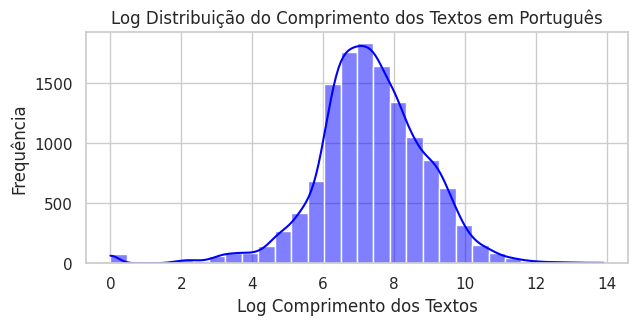

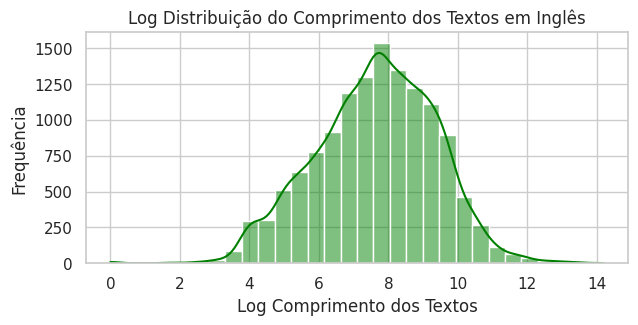

In [10]:
# Configura o estilo dos gráficos
sns.set(style="whitegrid")

# Histograma para a distribuição do comprimento dos textos em português2
plt.figure(figsize=(7, 3))
sns.histplot(log_lengths_pt, bins=30, color="blue", kde=True)
plt.title('Log Distribuição do Comprimento dos Textos em Português')
plt.xlabel('Log Comprimento dos Textos')
plt.ylabel('Frequência')
plt.show()

print()

# Histograma para a distribuição do comprimento dos textos em inglês.
plt.figure(figsize=(7, 3))
sns.histplot(log_lengths_en, bins=30, color="green", kde=True)
plt.title('Log Distribuição do Comprimento dos Textos em Inglês')
plt.xlabel('Log Comprimento dos Textos')
plt.ylabel('Frequência')
plt.show()


# Extrai a categoria principal de cada título, considerando que o texto após ':'a  representa.
def extract_category(title):
    parts = title.split(':')
    return parts[1] if len(parts) > 1 else 'Outros'

# Adiciona a coluna de categoria aos DataFrames
df1['category'] = df1['title'].apply(extract_category)
df2['category'] = df2['title'].apply(extract_category)


Análise dos histogramas de comprimento dos textos:

Após a transformação logarítmica, os histogramas mostram que os dois conjuntos de dados seguem uma distribuição log-normal, mostrando que textos mais curtos são comuns, com uma cauda longa indicando textos significativamente mais longos. A presença destes textos longos pode indicar materiais mais detalhados ou avançados.

Tranformação -> Segmentar textos mais longos em unidades menores mais gerenciáveis. Utilizar técnicas como truncamento, padding ou divisão de textos longos em várias partes para que o comprimento dos textos de entrada seja consistente.


#### Visualizando a distribuição das categorias encontradas >>

<ipython-input-11-490f8796bf43>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=df1, order=df1['category'].value_counts().index[:20], palette='viridis')


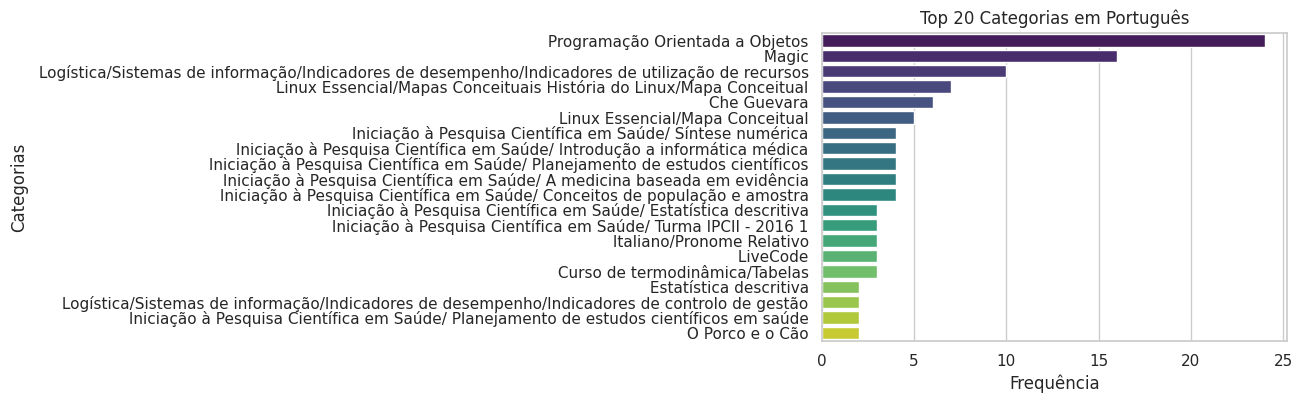

<ipython-input-11-490f8796bf43>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=df2, order=df2['category'].value_counts().index[:20], palette='viridis')


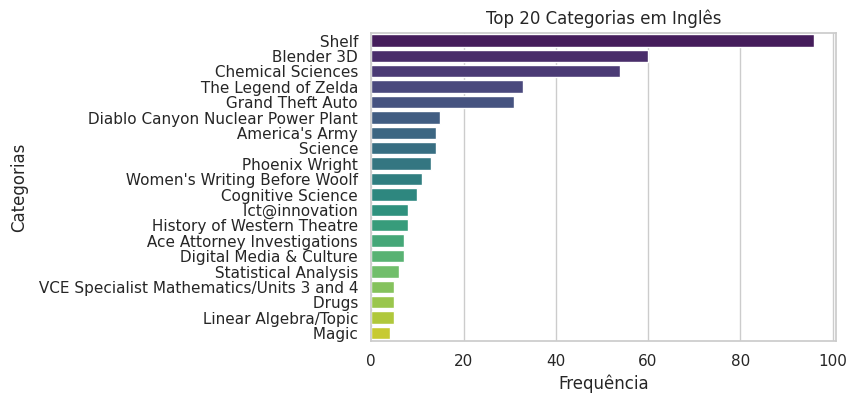

In [11]:
# Extrai a categoria principal de cada título, considerando que o texto após ':'a  representa.
def extract_category(title):
    parts = title.split(':')
    return parts[1] if len(parts) > 1 else 'Outros'

# Adiciona a coluna de categoria aos DataFrames
df1['category'] = df1['title'].apply(extract_category)
df2['category'] = df2['title'].apply(extract_category)

# Cria um gráfico de barras para as categorias em português.
# A visualização de barras para comparar a frequência de diferentes temas.
plt.figure(figsize=(6, 4))
sns.countplot(y='category', data=df1, order=df1['category'].value_counts().index[:20], palette='viridis')
plt.title('Top 20 Categorias em Português')
plt.xlabel('Frequência')
plt.ylabel('Categorias')
plt.show()

# Cria um gráfico de barras para as categorias em inglês.
plt.figure(figsize=(6, 4))
sns.countplot(y='category', data=df2, order=df2['category'].value_counts().index[:20], palette='viridis')
plt.title('Top 20 Categorias em Inglês')
plt.xlabel('Frequência')
plt.ylabel('Categorias')
plt.show()

Análise do gráfico de barras:

Os dois graficos mostram que existe uma grande quantidade de conteúdos, o que é perfeito para o nosso contexto, pois irá comtemplar inumeros assuntos.
Existem as categorias que tambem incluem subcategorias demilitadas por '/', oque acarreta uma frequencia muito maior nas categorias deste porte, e determinado grau de complexidade a mais.

Processamento e transformações necessárias:

1. Balanceamento de Tópicos

2. Piorização das categorias mais relevantes.

3. Separar o conteúdo para diferentes niveis de dificuldade

4. Buscar incluir material abrangente de um curso de inglês













# Pré-processamento dos Dados:




#### Balanceamento de tópicos, priorização de categorias e classificação de niveis de dificuldade >>

In [14]:
# Definir categorias com base nos gráficos
categorias_prioritarias_en = ['Shelf', 'Blender 3D', 'Chemical Sciences', 'The Legend of Zelda', 'Grand Theft Auto']

def balancear_topicos(df, n_target):
    df_balanced = pd.DataFrame()
    for categoria in df['category'].unique():
        df_cat = df[df['category'] == categoria]
        if len(df_cat) > n_target:
            df_cat = df_cat.sample(n_target, random_state=1)  # random_state para reprodutibilidade
        df_balanced = pd.concat([df_balanced, df_cat])
    return df_balanced.reset_index(drop=True)

def priorizar_categorias(df, categorias_prioritarias):
    df['prioridade'] = df['category'].isin(categorias_prioritarias).astype(int)
    return df

def classificar_dificuldade(df):
    # Configurar o vectorizer e o modelo de clusterização
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['body_text'])
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=1) # n_clusters para diferentes níveis de dificuldade

    # Classificar os textos em níveis de dificuldade
    df['nivel_dificuldade'] = kmeans.fit_predict(tfidf_matrix)
    return df

def processar_datasets(df_pt, df_en, categorias_prioritarias_en):
    # Ajustar os datasets para terem tamanhos semelhantes
    n_target = df_pt.shape[0]  # Usar o tamanho do dataset em português como alvo
    df_en_balanced = balancear_topicos(df_en, n_target)

    # Priorizar as categorias do dataset em inglês
    df_en_priorizado = priorizar_categorias(df_en_balanced, categorias_prioritarias_en)

    # Classificar os textos do dataset em inglês por nível de dificuldade
    df_en_classificado = classificar_dificuldade(df_en_priorizado)

    return df_pt, df_en_classificado



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Pré processamento de texto >>

In [15]:
# Função de Pré-processamento do Texto

def preprocess_text(text):
    # Preserva URLs, pois podem ser referências importantes ou recursos adicionais.
    # Preserva números e pontuações relevantes para o ensino de inglês.
    # Não converte o texto para minúsculas para manter a capitalização importante.
    # Tokeniza o texto em palavras para facilitar a análise linguística.

    # Separa pontuações dos tokens sem removê-las, pois são importantes gramaticalmente.
    text = re.sub(r'([,.!?])', r' \1 ', text)

    # Substitui múltiplos espaços por um único espaço.
    text = re.sub(r'\s{2,}', ' ', text)

    # Tokeniza o texto, mantendo pontuações como tokens individuais.
    tokens = word_tokenize(text)

    # Mantém stopwords já que são importantes para o aprendizado de uma nova língua.
    # Os tokens são reunidos de volta, incluindo stopwords e pontuações.
    processed_text = ' '.join(tokens)

    return processed_text


# Função para Segmentar Texto em Sentenças
def segment_text(text):
    # Segmenta o texto em sentenças
    return sent_tokenize(text)


# Função para Codificar e Aplicar Padding ao Texto
def encode_and_pad(texts, max_length=100, vocab_size=30000, oov_token="<OOV>"):
    # Inicializa o tokenizer com um tamanho de vocabulário limitado e token para palavras fora do vocabulário.
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

    # Ajusta o tokenizer ao texto, construindo um vocabulário limitado ao tamanho de vocab_size.
    tokenizer.fit_on_texts(texts)

    # Transforma os textos em sequências numéricas, substituindo palavras fora do vocabulário pelo oov_token.
    sequences = tokenizer.texts_to_sequences(texts)

    # Aplica padding às sequências para que todas tenham o mesmo tamanho.
    # A escolha entre 'pre' ou 'post' padding será informada pela arquitetura do modelo.
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    return padded_sequences, tokenizer


# Função para Aplicar o Pré-processamento
def apply_preprocessing(df, text_columns):
    for column in text_columns:
        # Aplica a função de pré-processamento em cada coluna especificada e armazena os resultados em novas colunas.
        df[f'cleaned_{column}'] = df[column].apply(preprocess_text)
        # Segmenta o texto processado e armazena em outra nova coluna.
        df[f'segmented_{column}'] = df[f'cleaned_{column}'].apply(segment_text)
    return df


#### Aplicando o pré processamento nos Datasets >>

In [16]:
# Aplicando o processamento de tópicos em df1 e df2
df1_processado, df2_processado = processar_datasets(df1, df2, categorias_prioritarias_en)

# Colunas de texto em df1 e df2
text_columns_df1 = ['title', 'abstract', 'body_text']
text_columns_df2 = ['title', 'abstract', 'body_text']

# Aplicando pré-processamento de texto em df1 e df2
df1 = apply_preprocessing(df1, text_columns_df1)
df2 = apply_preprocessing(df2, text_columns_df2)

# Codificação e padding para as colunas 'cleaned_body_text' dos Dataframes
padded_texts_df1, tokenizer_df1 = encode_and_pad(df1['cleaned_body_text'].tolist())
padded_texts_df2, tokenizer_df2 = encode_and_pad(df2['cleaned_body_text'].tolist())

# Visualizar os resultados do pré-processamento
print("DF1 - Cleaned Texts:")
print(df1['cleaned_body_text'].head())
print("\nDF1 - Padded Texts Example:", padded_texts_df1[0])

print("\nDF2 - Cleaned Texts:")
print(df2['cleaned_body_text'].head())
print("\nDF2 - Padded Texts Example:", padded_texts_df2[0])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


DF1 - Cleaned Texts:
0    acima : < < < Índiceanterior : < < < Salgados ...
1    O que é ? O que é escotismo ? O escoteiro Prop...
2    O Maul acontece quando três jogadores , sendo ...
3    Índice 1 Paralelas 2 Perpendiculares 3 Feixe d...
4    Etapas de desenvolvimento - 9 fases Início : B...
Name: cleaned_body_text, dtype: object

DF1 - Padded Texts Example: [ 3597    26   237   541     1    18    24  7909  1977     9   735   890
   337    11  8819    32     8     8    22    23   146     5   122     8
     8    22    23    10   494     2   412     2   542    10   974   882
     2  6325    10   377   241     2   395  2022   469     2   555  3013
   122  1518    18   115     5  6701   189  1403   104   541   719     3
   337 19932   326   541  2566     3   337     5   725     3     9  7909
    16  1823     3   754     5  1880 11858    26   695    16  4806 12322
   725    39   735   890    11  1977   150   366  2152  2621     5  2762
   198  8819     9   204]

DF2 - Cleaned Texts:
6708

# 4. Análise Aprofundada nos Dados









#### Analise de profundidade do conteúdo para verificar a complexidade dos dados >>

In [17]:

# Baixar as stopwords em inglês
nltk.download('stopwords')
nltk.download('punkt')

# Função para calcular a profundidade de conteúdo
def content_depth_analysis(texts):
    # Tokenização e remoção de stopwords
    stop_words = set(stopwords.words('english'))
    tokenized_words = [word for text in texts for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]

    # Cálculo do tamanho médio das palavras
    avg_word_length = sum(len(word) for word in tokenized_words) / len(tokenized_words)

    # Cálculo da diversidade lexical
    lexical_diversity = len(set(tokenized_words)) / len(tokenized_words)

    # Contagem de termos técnicos
    technical_terms = ['mathematics', 'history', 'science', 'education', 'technology']  # Termos técnicos de exemplo
    technical_term_counts = Counter(word for word in tokenized_words if word in technical_terms)

    # Imprimir os resultados
    print("Tamanho médio das palavras:", avg_word_length)
    print("Diversidade lexical:", lexical_diversity)
    print("Contagem de termos técnicos:", technical_term_counts)

# Aplicar a análise de profundidade de conteúdo aos textos
content_depth_analysis(pd.concat([df1['body_text'], df2['body_text']]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tamanho médio das palavras: 5.82310941056622
Diversidade lexical: 0.028454807939549815
Contagem de termos técnicos: Counter({'technology': 4745, 'history': 4140, 'education': 3610, 'science': 2825, 'mathematics': 779})



Com base nos resultados da análise de profundidade de conteúdo, parece que os textos têm uma complexidade linguística razoável, uma diversidade vocabular satisfatória e abordam uma variedade de assuntos relevantes. Esses são aspectos positivos que indicam uma boa adequação dos materiais para nosso projeto educacional de ensino de inglês.

O tamanho médio das palavras sugere que os textos estão em um nível intermediário de complexidade, o que pode ser adequado para alunos que já têm alguma familiaridade com o idioma. Além disso, a diversidade lexical indica uma variedade razoável de vocabulário, o que é benéfico para enriquecer as habilidades de compreensão e expressão dos alunos.

A contagem de termos técnicos revela que os textos cobrem uma ampla gama de assuntos acadêmicos e disciplinas, o que é importante para proporcionar uma experiência de aprendizado abrangente e enriquecedora. Portanto, com base nessas métricas, os materiais parecem ser adequados para os objetivos educacionais do projeto de ensino de inglês.

### Analise de sentimentos e tendencias >>

In [ ]:
# Avaliar a adequação emocional dos recursos educacionais que teremos a partir dos dados

### Análise de Coocorrência de Palavras >>

In [ ]:
# Explore como diferentes palavras são usadas juntas, que pode ajudar no desenvolvimento de lições de contexto de vocabulário.

### Mistura de amostras (data augmentation) e embaralhamento >>

In [ ]:
# Para diversificar o conjunto de treinamento e evitar viés durante o treinamento.

### Validação de Dados >>

In [ ]:
# Verifique a integridade e a adequação dos dados processados
# para garantir que estão prontos para serem utilizados em treinamentos de modelos de PNL.


# Definição e Treinamento do Modelo:




Escolha da arquitetura do modelo (GPT).



Definição e compilação do modelo de PNL.



Treinamento do modelo utilizando os dados preparados.


# Avaliação e ajuste do Modelo:




Usando métricas para avaliação do desempenho do modelo



Análise dos resultados

# Geração de respostas em linguagem natural


# Interação com o Usuário:





Implementação de uma interface de usuário para interação com o algoritmo professor de inglês.



Processamento de consultas do usuário e geração de respostas.

# Testes e Validação:



Testes do sistema em diferentes cenários e condições.



Validação da eficácia e precisão das respostas geradas.

# Integração e Implantação:



Integração do algoritmo professor de inglês em uma aplicação ou plataforma de ensino de inglês.



Implantação do sistema para uso em produção.